# Прогнозирование вероятности оттока пользователей для фитнес-центров

**Описание проекта:**

Сеть фитнес-центров «Культурист-датасаентист» разрабатывает стратегию взаимодействия с клиентами на основе аналитических данных. 
Распространённая проблема фитнес-клубов и других сервисов — отток клиентов. Чтобы понять, что клиент больше не с вами, можно записать в отток тех, кто попросил закрыть договор или удалил аккаунт. Однако клиенты не всегда уходят демонстративно: чаще перестают пользоваться сервисом тихо. 

Для фитнес-центра можно считать, что клиент попал в отток, если за последний месяц ни разу не посетил спортзал. Конечно, не исключено, что он уехал в отпуск и по возвращению обязательно продолжит ходить на фитнес. Однако чаще бывает наоборот. Если пользователь начал новую жизнь с понедельника, немного походил в спортзал, а потом пропал — скорее всего, он не вернётся. 

Чтобы бороться с оттоком, отдел по работе с клиентами «Культуриста-датасаентиста» перевёл в электронный вид множество клиентских анкет. 

**Цель исследования:** 
    
Проведение анализа и подготовка плана действий по удержанию пользователей фитнес-центра:

 - прогнозирование вероятности оттока (на уровне следующего месяца) для каждого пользователя;
 
 - формирование типичных портретов пользователей: выделение несколько наиболее ярких групп и дать характеристику их основным свойствам;
 
 - анализ основных признаков, наиболее сильно влияющих на отток;
 
 - формиулирование выводов и разработка рекомендаций по повышению качества работы с клиентами:
 
     - 1) выделить целевые группы клиентов;
     - 2) предложить меры по снижению оттока;
     - 3) определить другие особенности взаимодействия с клиентами.

 **Описание данных**:

Файл `gym_churn.csv` содержит данные на месяц до оттока и факт оттока на определённый месяц:

 - **Данные клиента за предыдущий до проверки факта оттока месяц:**
 
     - `gender` — пол;
     - `Near_Location` — проживание или работа в районе, где находится фитнес-центр;
     - `Partner` — сотрудник компании-партнёра клуба (сотрудничество с компаниями, чьи сотрудники могут получать скидки на абонемент — в таком случае фитнес-центр хранит информацию о работодателе клиента);
     - `Promo_friends` — факт первоначальной записи в рамках акции «приведи друга» (использовал промо-код от знакомого при оплате первого абонемента);
     - `Phone` — наличие контактного телефона;
     - `Age` — возраст;
     - `Lifetime` — время с момента первого обращения в фитнес-центр (в месяцах).
     
     
 - **Информация на основе журнала посещений, покупок и информация о текущем статусе абонемента клиента:**
 
     - `Contract_period` — длительность текущего действующего абонемента (месяц, 6 месяцев, год);
     - `Month_to_end_contract` — срок до окончания текущего действующего абонемента (в месяцах);
     - `Group_visits` — факт посещения групповых занятий;
     - `Avg_class_frequency_total` — средняя частота посещений в неделю за все время с начала действия абонемента;
     - `Avg_class_frequency_current_month` — средняя частота посещений в неделю за предыдущий месяц;
     - `Avg_additional_charges_total` — суммарная выручка от других услуг фитнес-центра: кафе, спорттовары, косметический и массажный салон.
     
 - `Churn` — факт оттока в текущем месяце.

## Обзор данных

In [1]:
#Импортируем библиотеки
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.cluster import KMeans
from scipy.cluster.hierarchy import dendrogram
from scipy.cluster.hierarchy import linkage 
pd.options.display.max_colwidth = 1

In [2]:
! pip install phik
from phik import phik_matrix

In [3]:
import warnings
warnings.filterwarnings('ignore')

Прочитаем файл и сохраним в переменной `gym`.

In [4]:
try:
    gym = pd.read_csv('/datasets/gym_churn.csv') 
except:
    gym = pd.read_csv('https://code.s3.yandex.net/datasets/gym_churn.csv')

Получим общую информацию о таблице.

In [5]:
gym.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 14 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   gender                             4000 non-null   int64  
 1   Near_Location                      4000 non-null   int64  
 2   Partner                            4000 non-null   int64  
 3   Promo_friends                      4000 non-null   int64  
 4   Phone                              4000 non-null   int64  
 5   Contract_period                    4000 non-null   int64  
 6   Group_visits                       4000 non-null   int64  
 7   Age                                4000 non-null   int64  
 8   Avg_additional_charges_total       4000 non-null   float64
 9   Month_to_end_contract              4000 non-null   float64
 10  Lifetime                           4000 non-null   int64  
 11  Avg_class_frequency_total          4000 non-null   float

В таблице 14 столбцов и 4000 строк, пропуски отсутствуют. 
По большей части все признаки категориальные. К числовым признакам относятся столбцы: 
 - `Avg_class_frequency_total`: средняя частота посещений в неделю за все время;
 - `Avg_class_frequency_current_month`: средняя частота посещений в неделю за предыдущий месяц;
 - `Avg_additional_charges_total`: суммарная выручка от других услуг фитнес-центра

Приведем названия столбцов к нижнему регистру. 

In [6]:
#Приводим названия столбцов к нижнему регистру. 
gym.columns = gym.columns.str.lower()

Выведем первые пять строк таблицы `gym`

In [7]:
gym.head()

,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month,churn
0,1,1,1,1,0,6,1,29,14.227470,5.0,3,0.020398,0.000000,0
1,0,1,0,0,1,12,1,31,113.202938,12.0,7,1.922936,1.910244,0
2,0,1,1,0,1,1,0,28,129.448479,1.0,2,1.859098,1.736502,0
3,0,1,1,1,1,12,1,33,62.669863,12.0,2,3.205633,3.357215,0
4,1,1,1,1,1,1,0,26,198.362265,1.0,3,1.113884,1.120078,0


Поменяем вещественные значения столбца `month_to_end_contract` на цельночисленные.

In [8]:
gym['month_to_end_contract'] = gym['month_to_end_contract'].astype('int')

**Вывод:** произведен первичный обзор данных. У нас есть сведения о 4000 клиентах фитнес-центра, и по каждому клиенту 14 колонок-атрибутов, включая целевую переменную `churn`. Пропуски отсутствуют.

Большинство признаков являются категориальными. К числовым признакам относятся столбцы: 
 - `Avg_class_frequency_total`: средняя частота посещений в неделю за все время;
 - `Avg_class_frequency_current_month`: средняя частота посещений в неделю за предыдущий месяц;
 - `Avg_additional_charges_total`: суммарная выручка от других услуг фитнес-центра

## Исследовательский анализ данных.

### Обзор признаков.

In [9]:
#Проверим строки таблицы на наличие дубликатов:
gym.duplicated().sum()

0

Дубликаты отсутствуют.

In [10]:
#Выведем список характерных значений
gym.describe()

,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month,churn
count,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000
mean,0.510250,0.845250,0.486750,0.308500,0.903500,4.681250,0.412250,29.184250,146.943728,4.322750,3.724750,1.879020,1.767052,0.265250
std,0.499957,0.361711,0.499887,0.461932,0.295313,4.549706,0.492301,3.258367,96.355602,4.191297,3.749267,0.972245,1.052906,0.441521
min,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,18.000000,0.148205,1.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,27.000000,68.868830,1.000000,1.000000,1.180875,0.963003,0.000000
50%,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,29.000000,136.220159,1.000000,3.000000,1.832768,1.719574,0.000000
75%,1.000000,1.000000,1.000000,1.000000,1.000000,6.000000,1.000000,31.000000,210.949625,6.000000,5.000000,2.536078,2.510336,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,12.000000,1.000000,41.000000,552.590740,12.000000,31.000000,6.023668,6.146783,1.000000


По информации от заказчика в бинарных столбцах `gender`, `near_location`, `partner`, `promo_friends`, `phone`, `group_visits`, `churn`:

 - значение **1** означает значение признака **да**;
 - значение **0** означает значение признака **нет**



- по признаку `gender` распределение между мужчинами и женщинами одинаковое;
 - 84% пользователей проживают или работают рядом с фитнес-центром;
 - почти половина клиентов являются сотрудниками компаний-партнеров клуба и получают скидку на абонемент;
 - 30% клиентов привлечены в рамках акции "приведи друга";
 - фитнес-центр обладает телефонами 90% своих пользователей; соответственно 10% клиентов отказались указать свои номера телефонов;
 - почти половина пользователей: 41% посещают групповые занятия;
 - 26% клиентов попадут в отток в следующем месяце (перестанут посещать занятия)
 
 В столбце `avg_additional_charges_total` наблюдаются небольшие выбросы, медианная выручка от других услуг 146 у.е.
 
 Средний возраст посетителя фитнес-центра составляет 29 лет.
 
 Средняя частота посещений фитнес-центра за предыдущий месяц составляет 1.71 раз в неделю.
 
 Средняя частота посещений фитнес-центра за все время составляет 1.83 раз в неделю.
 
 

Напишем функцию, которая для категориальных признаков построит графики типа `bar`, а для количественных признаков построит гистограммы.

In [11]:
def plot(data):
    # Определение категориальных и количественных признаков
    categorical_features = [col for col in data.columns if data[col].nunique() <= 12 and data[col].dtype == 'int64']
    numerical_features = [col for col in data.columns if data[col].dtype in ['int64', 'float64'] and col not in categorical_features]

    # Строим графики для категориальных признаков
    for feature in categorical_features:
        plt.figure(figsize=(8, 3))
        sns.countplot(x=feature, data=data, palette="viridis")
        plt.title(f'Распределение значений признака {feature}')
        plt.show()

    # Строим гистограммы для количественных признаков
    for feature in numerical_features:
        plt.figure(figsize=(8, 3))
        sns.histplot(data[feature], kde=True, color="skyblue")
        plt.title(f'Гистограмма признака {feature}')
        plt.show()

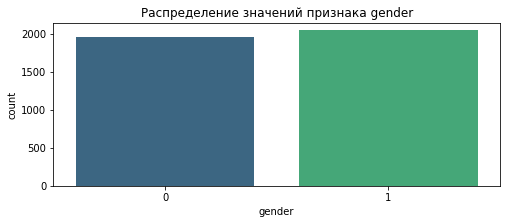

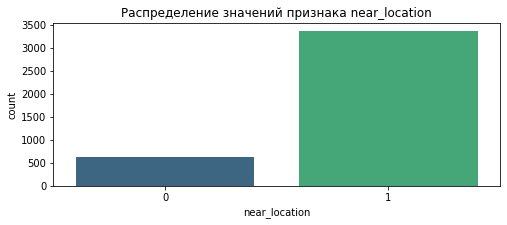

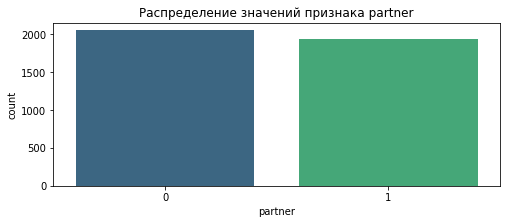

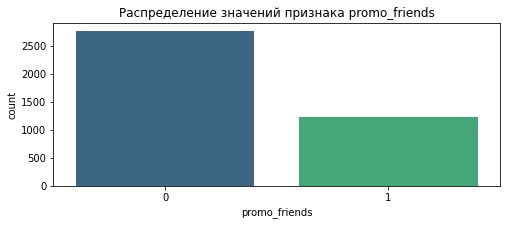

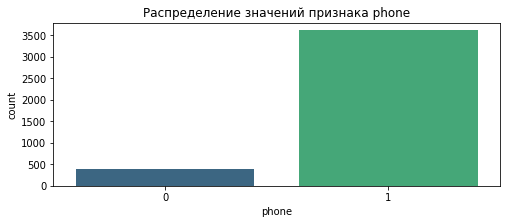

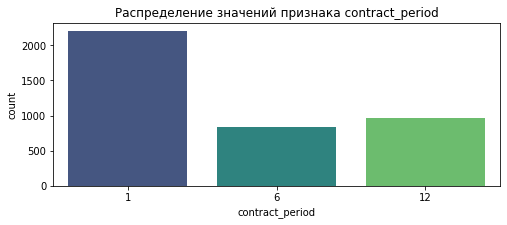

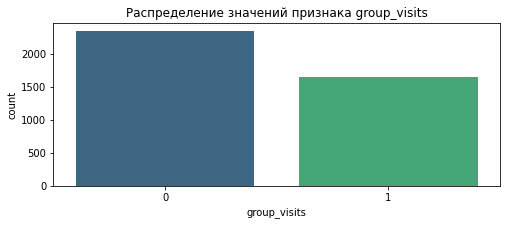

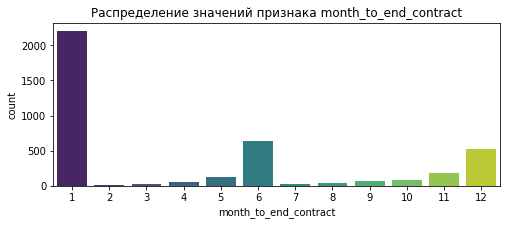

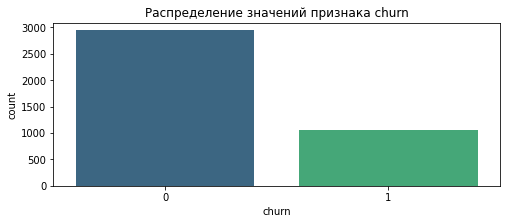

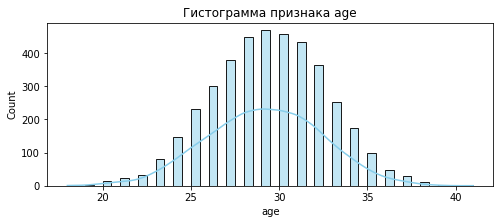

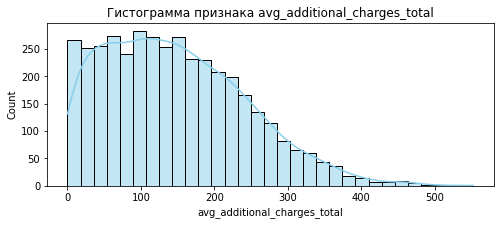

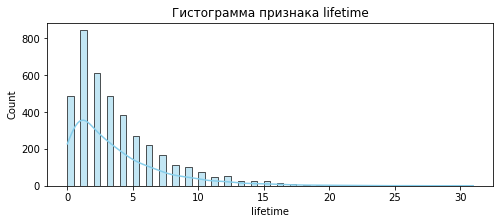

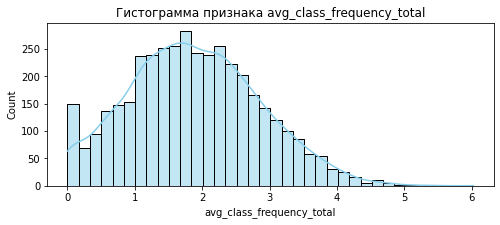

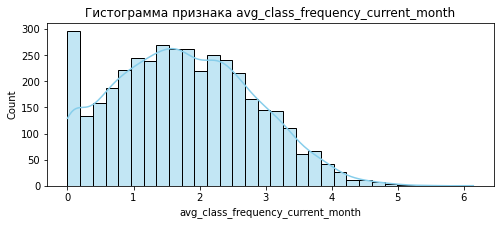

In [12]:
#вызываем функцию
plot(gym)

Признак `age` имеет нормальное распределение. В столбце `avg_class_frequency_current_month` наблюдаются небольшие выбросы на нулевом значении: большое количество людей, которые за предыдущий месяц не посещали фитнес-центр. Посмотрим на этих пользователей более детально. 

In [13]:
#Посмотрим на уникальные значения признака lifetime
gym['lifetime'].unique()

array([ 3,  7,  2,  0,  1, 11,  4,  8, 14,  6,  5, 15, 12, 21, 10, 20,  9,
       13, 17, 16, 24, 22, 31, 26, 23, 18, 19, 27, 29])

In [14]:
#В переменную сохраняем пользователей, у которые среднее число посещений за предыщий месяц стремится к нулю
new_users = gym.loc[gym['avg_class_frequency_current_month'] == 0][['avg_class_frequency_current_month', 'lifetime']]

In [15]:
#Посмотрим, на время после первого обращения для пользователей, не посещавших занятия в прошлом месяце
new_users['lifetime'].unique()

array([ 3,  1,  0, 10,  2,  4,  9, 17, 11, 12,  7, 27,  5,  6, 16])

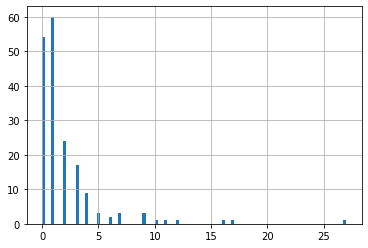

In [16]:
#Построим гистограмму и посмотрим на распределение клиентов
new_users['lifetime'].hist(bins=100);

Клиенты, которые не посещали фитнес-центр за предыдущий месяц являются в большинстве случаев новыми клиентами или клиентами, которые прекратили посещать занятия через месяц, после первого обращения.

### Средние значения признаков

Посмотрим на средние значения признаков двух групп: тех, кто ушел в отток, и тех, кто остался.

In [17]:
gym_mean = gym.groupby(['churn']).mean().T
gym_mean.columns = ['stay', 'churn']
gym_mean

,stay,churn
gender,0.510037,0.510839
near_location,0.873086,0.768143
partner,0.534195,0.355325
promo_friends,0.353522,0.183789
phone,0.903709,0.902922
contract_period,5.747193,1.728558
group_visits,0.464103,0.268615
age,29.976523,26.989632
avg_additional_charges_total,158.445715,115.082899
month_to_end_contract,5.283089,1.662582


Можно сделать вывод, что такие признаки, как:
 - пол, 
 - проживание или работа в районе, где находится фитнес-центр,
 - наличие телефона
 
не влияют на значение целевой переменной, поскольку средние значения признаков для обеих групп (ушедших в отток и оставшихся) одинаковые.



### Столбчатые гистограммы и распределения признаков для тех, кто ушёл (отток) и тех, кто остался (не попали в отток).

Для числовых признаков построим гистограммы и диаграммы размаха для клиентов, ушедших в отток и оставшихся посещать занятия.

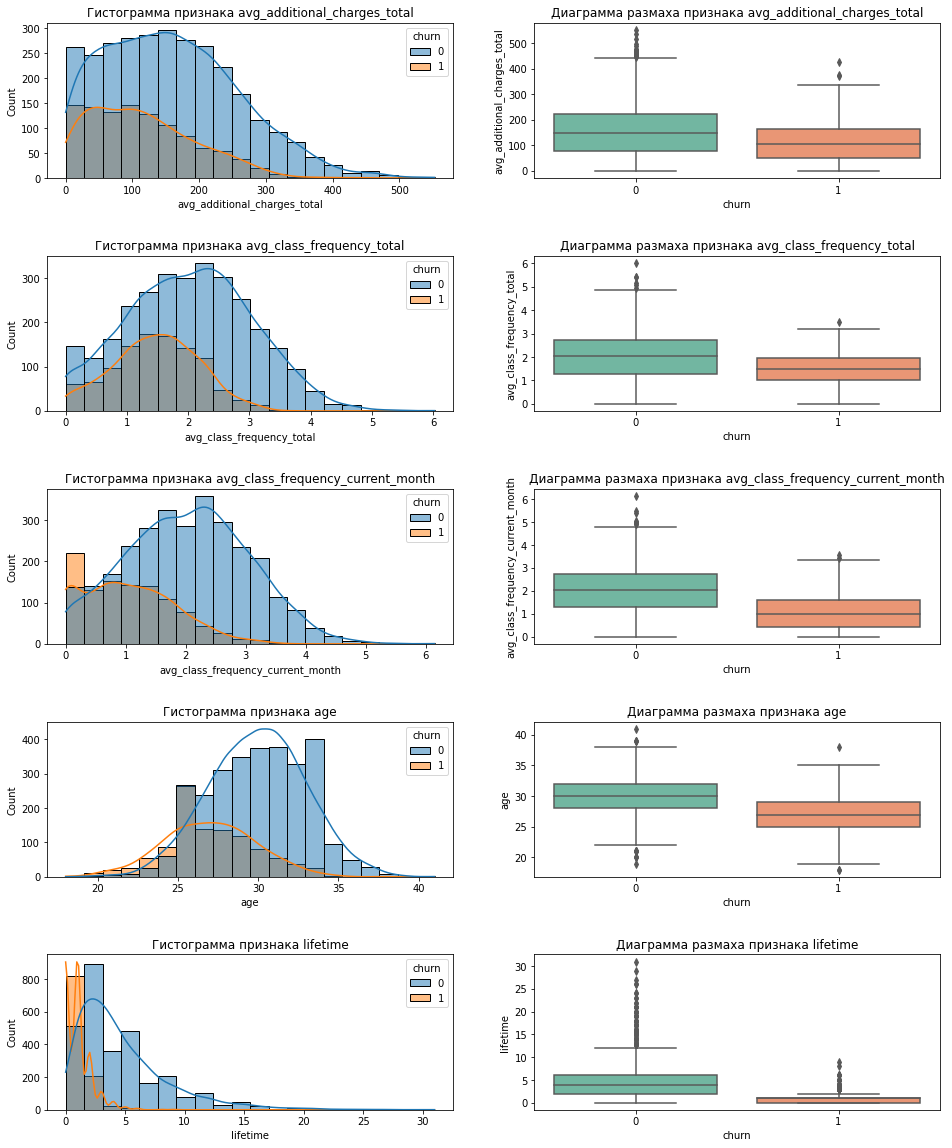

In [18]:
def plot_histogram_boxplot(dataset, numerical_columns):
    # Вычисляем количество количественных признаков
    num_numerical_columns = len(numerical_columns)

    # Рассчитываем количество строк и столбцов для subplot
    num_rows = num_numerical_columns
    num_cols = 2

    # Создаем subplot с учетом отступов
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(16, 4 * num_rows), gridspec_kw={'hspace': 0.5, 'wspace': 0.2})

    # Разделяем саблоты на два списка
    histogram_axes = axes[:, 0]
    boxplot_axes = axes[:, 1]

    # Строим гистограммы
    for i in range(num_numerical_columns):
        col = numerical_columns[i]

        if col in dataset.columns:
            # Гистограмма
            sns.histplot(
                data=dataset,
                x=col, hue='churn', 
                bins=20, ax=histogram_axes[i], 
                color="skyblue", 
                edgecolor='black', 
                kde=True,
                
                alpha=0.5
            )
            histogram_axes[i].set_title(f'Гистограмма признака {col}')
        else:
            print(f"Column {col} not found in the dataset.")

    # Строим диаграммы размаха
    for i in range(num_numerical_columns):
        col = numerical_columns[i]

        if col in dataset.columns:
            # Boxplot
            sns.boxplot(x='churn', y=col, data=dataset, ax=boxplot_axes[i], palette='Set2')
            boxplot_axes[i].set_title(f'Диаграмма размаха признака {col}')
        else:
            print(f"Column {col} not found in the dataset.")

    # Размещаем subplot
    plt.tight_layout()
    plt.show()


numerical_columns_list = [
    'avg_additional_charges_total', 'avg_class_frequency_total', 'avg_class_frequency_current_month',
    'age', 'lifetime'
]
plot_histogram_boxplot(gym, numerical_columns_list)

Визуализируем распределение категориальных признаков 

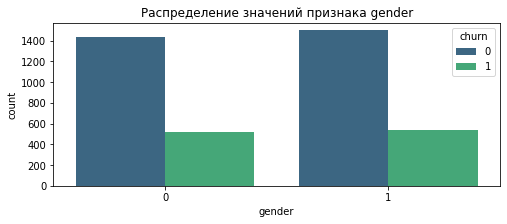

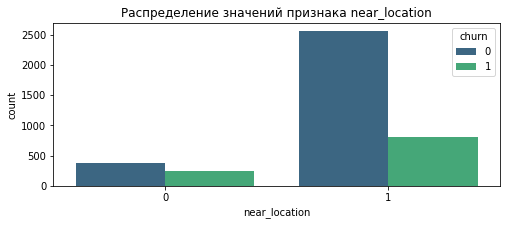

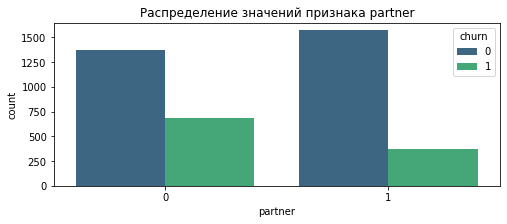

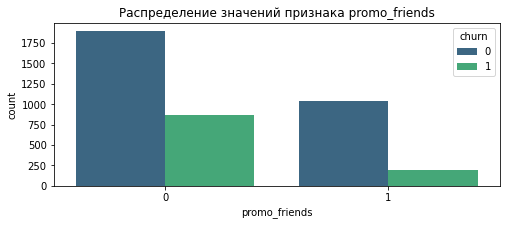

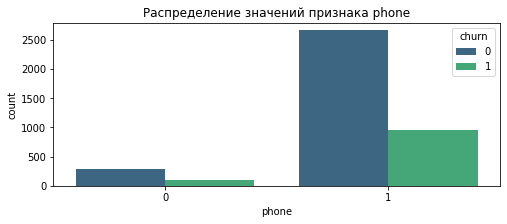

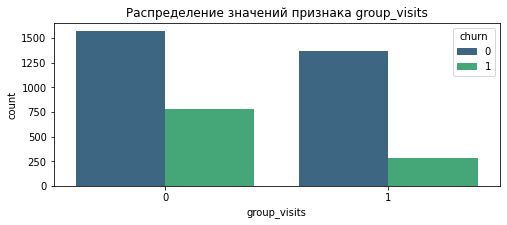

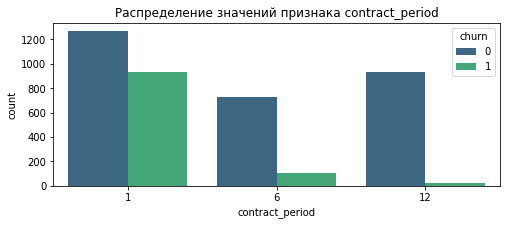

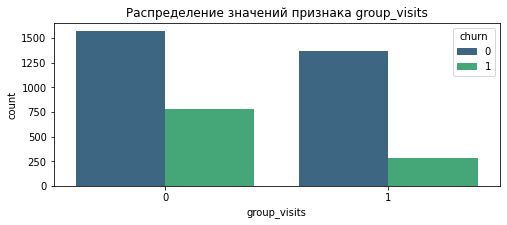

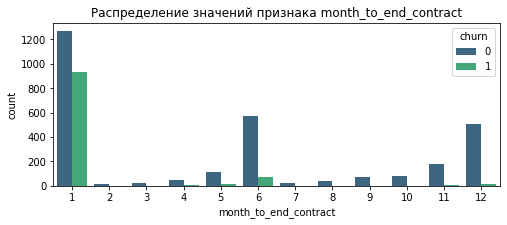

In [19]:
categorical_features_list = [
    'gender', 'near_location', 'partner', 'promo_friends', 'phone', \
    'group_visits', 'contract_period', 'group_visits', 'month_to_end_contract'
]

for feature in categorical_features_list:
    plt.figure(figsize=(8, 3))
    sns.countplot(x=feature, hue='churn', data=gym, palette="viridis")
    plt.title(f'Распределение значений признака {feature}')
    plt.show()

- среди оставшихся более половины клиентов являются сотрудниками компании-партнера клуба и пользуются скидками, а среди ушедших в отток всего лишь треть таких клиентов. Можно сделать вывод, что признак принадлежности клиента к сотрудникам компании партнера-клуба оказывает положительное влияние на удержание пользователя, в то время, как среди ушедших в отток клиентов больше тех, кто не является сотрудником партнера.

- среди оставшихся пользователей 35% использовали промокод в рамках акции "приведи друга", в то время, как среди ушедших в отток таких пользователей всего лишь 18%.
 
- среди оставшихся пользователей средняя длительность действующего абонемента намного больше, чем среди ушедших в отток: почти полгода против 1.72 месяца, показатели почти совпадают и со средним сроком до окончания текущего действующего абонемента.

- почти половина среди оставшихся клиентов посещают групповые занятия, среди ушедших в отток таких клиентов всего четверть.

- средний возраст оставшихся клиентов на три года старше среднего возраста клиентов, ушедших в отток: 30 лет и 27 лет.

- оставшиеся пользователи охотнее пользуются дополнительными услугами фитнес-центра: средняя суммарная выручка составляет 158 тыс. у.е, среди ушедших в отток средняя суммарная выручка 115 тыс. у.е. 

- среди оставшихся пользователей гораздо больше "долгожителей": время с момента первого обращения в фитнес-центр составляет 4.7 месяцев, среди ушедших в отток лайфтайм составляет около одного месяца.

- оставшиеся пользователи в среднем в текущем месяце посещают тренировки 2 раза в неделю, пользователи, ушедшие в отток посещали в среднем полтора раза в неделю, а за предыдущий месяц ушедшие в отток посещали занятия всего лишь один раз в неделю.


#### Матрица корреляций

Построим тепловую карту по матрице корреляций, применим библиотеку phik и метод `phik_matrix`, их особенность заключается в работе с разными типами данных, в том числе категориальными, а также учете нелинейных отношений.

interval columns not set, guessing: ['gender', 'near_location', 'partner', 'promo_friends', 'phone', 'contract_period', 'group_visits', 'age', 'avg_additional_charges_total', 'month_to_end_contract', 'lifetime', 'avg_class_frequency_total', 'avg_class_frequency_current_month', 'churn']


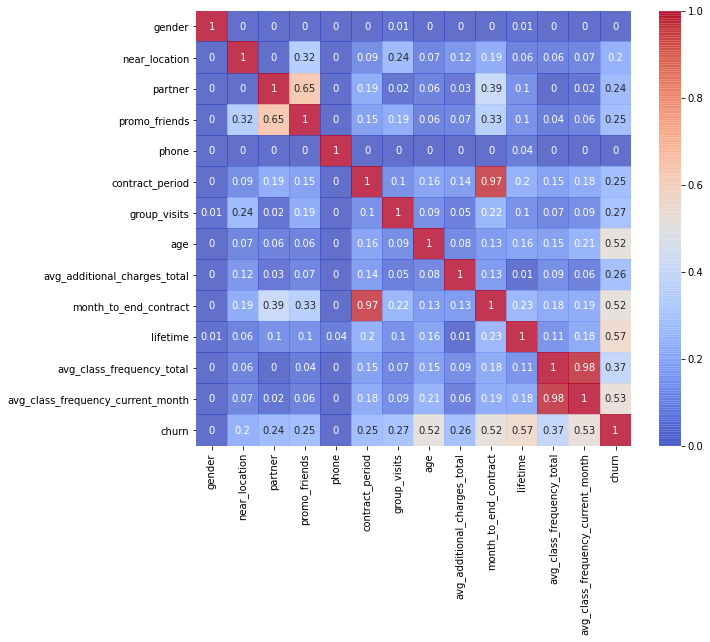

In [20]:

#Создаем матрицу с помощью phik
phik_corr_matrix = gym.phik_matrix()

#Строим heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(phik_corr_matrix.round(2), annot=True, square=True, alpha=0.8, cmap='coolwarm');


Тепловая карта показывает, что признаки `month_to_end_contract`, `contract_period` и `avg_class_frequency_current_month`, `avg_class_frequency_total` сильно коррелируют. Данные признаки мультиколлинеарны. 

Наблюдается слабая линейная связь практически между всеми признаками, однако такие признаки, как пол и наличие телефона не отражают никаких связей с другими признаками.

Видна средняя заметная связь между категориальными признаками `promo_friends` и `partner`, можно предположить, что участники акции "приведи друга" являются в небольшой доле сотрудниками компании-партнера, и привлекают новых клиентов среди своих коллег, однако такая гипотеза требует отдельного исследования. 

Наблюдается средняя умеренная корреляция между категориальными признаками `partner` и `month_to_end_contract`: скорее всего сотрудники компании-партнера охотнее приобретают абонементы.

С категориальной целевой переменной `churn` сильнее всего коррелирует признак `lifetime` - корреляция заметная, а также такие признаки, как `age`, `month_to_end_contract`, `avg_class_frequency_current_month`.



Для уменьшения вероятности переобучения модели, на основании мультиколлинеарных признаков, введем новые признаки: остаток абонемента и среднее значение посещений с поправкой на количество посещений предыдущей недели. 

In [21]:
# остаток абонемента
gym['part_abonem'] = gym['month_to_end_contract']/gym['contract_period']

In [22]:
# среденее значение посещений с поправкой на количество посещений предыдущей недели
gym['avg_frequency_mean'] = ((gym['avg_class_frequency_total']+gym['avg_class_frequency_current_month'])/2)

In [23]:
# удаляем лишние столбцы
gym = gym.drop(
    ['month_to_end_contract','avg_class_frequency_total','avg_class_frequency_current_month', 'contract_period'],axis = 1
)                 
                

Заново построим матрицу корреляций.

interval columns not set, guessing: ['gender', 'near_location', 'partner', 'promo_friends', 'phone', 'group_visits', 'age', 'avg_additional_charges_total', 'lifetime', 'churn', 'part_abonem', 'avg_frequency_mean']


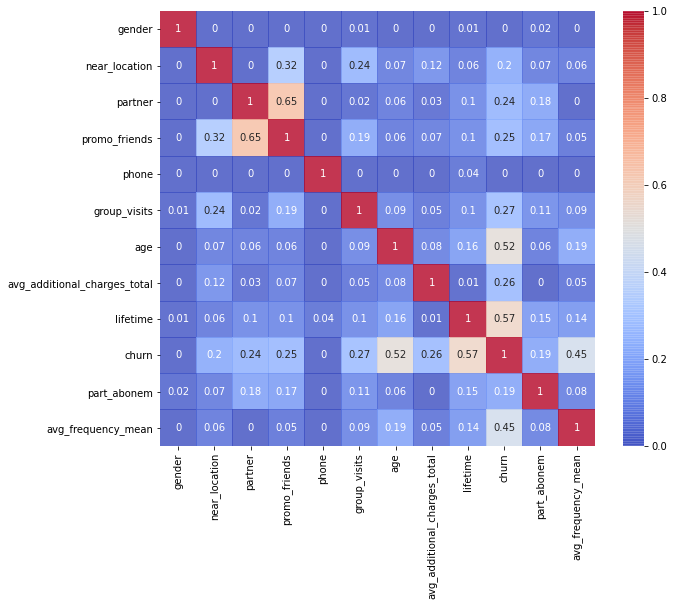

In [24]:

#Создаем матрицу с помощью phik
phik_corr_matrix = gym.phik_matrix()

#Строим heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(phik_corr_matrix.round(2), annot=True, square=True, alpha=0.8, cmap='coolwarm');

Наибольшая заметная корреляция с целевой переменной наблюдается у признаков возраст пользователя и лайфтайм, умеренная корреляция со среденим значением посещений с поправкой на количество посещений предыдущей недели. 

**Вывод:**

 В данных отсутствуют дубликаты.

 - по признаку `gender` распределение между мужчинами и женщинами одинаковое;
 - 84% пользователей проживают или работают рядом с фитнес-центром;
 - почти половина клиентов являются сотрудниками компаний-партнеров клуба и получают скидку на абонемент;
 - 30% клиентов привлечены в рамках акции "приведи друга";
 - фитнес-центр обладает телефонами 90% своих пользователей; соответственно 10% клиентов отказались указать свои номера телефонов;
 - почти половина пользователей: 41% посещают групповые занятия;
 - 26% клиентов попадут в отток в следующем месяце (перестанут посещать занятия)
 
 - в столбце `avg_additional_charges_total` наблюдаются небольшие выбросы, медианная выручка от других услуг 146 у.е.
 
 - средний возраст посетителя фитнес-центра составляет 29 лет.
 
 - средняя частота посещений фитнес-центра за предыдущий месяц составляет 1.71 раз в неделю.
 
 - средняя частота посещений фитнес-центра за все время составляет 1.83 раз в неделю.
 
 
 - на гистограмме наблюдается большое количество людей, которые за предыдущий месяц не посещали фитнес-центр: в большинстве случаев такие пользователи являются новыми клиентами или клиентами, которые прекратили посещать занятия через месяц, после первого обращения.
 
Изучены средние значения признаков, по которым сформированы выводы: 

 - такие признаки, как: пол, близость проживания или работа возле фитнесс-центра, наличие телефона в базе фитнес-центра не влияют на значения целевой переменной.

- среди оставшихся более половины клиентов являются сотрудниками компании-партнера клуба и пользуются скидками, а среди ушедших в отток всего лишь треть таких клиентов. Можно сделать вывод, что признак принадлежности клиента к сотрудникам компании партнера-клуба оказывает положительное влияние на удержание пользователя, в то время, как среди ушедших в отток клиентов больше тех, кто не является сотрудником партнера.

- среди оставшихся пользователей 35% использовали промокод в рамках акции "приведи друга", в то время, как среди ушедших в отток таких пользователей всего лишь 18%.
 
- среди оставшихся пользователей средняя длительность действующего абонемента намного больше, чем среди ушедших в отток: почти полгода против 1.72 месяца, показатели почти совпадают и со средним сроком до окончания текущего действующего абонемента.

- почти половина среди оставшихся клиентов посещают групповые занятия, среди ушедших в отток таких клиентов всего четверть.

- средний возраст оставшихся клиентов на три года старше среднего возраста клиентов, ушедших в отток: 30 лет и 27 лет.

- оставшиеся пользователи охотнее пользуются дополнительными услугами фитнес-центра: средняя суммарная выручка составляет 158 тыс. у.е, среди ушедших в отток средняя суммарная выручка 115 тыс. у.е. 

- среди оставшихся пользователей гораздо больше "долгожителей": время с момента первого обращения в фитнес-центр составляет 4.7 месяцев, среди ушедших в отток лайфтайм составляет около одного месяца.

- оставшиеся пользователи в среднем в текущем месяце посещают тренировки 2 раза в неделю, пользователи, ушедшие в отток посещали в среднем полтора раза в неделю, а за предыдущий месяц ушедшие в отток посещали занятия всего лишь один раз в неделю.

- Признаки `month_to_end_contract`, `contract_period` и `avg_class_frequency_current_month`, `avg_class_frequency_total` мультиколлинеарны, поэтому принято решение для уменьшения вероятности переобучения модели, на основании мультиколлинеарных признаков, ввести новые признаки: остаток абонемента и среднее значение посещений с поправкой на количество посещений предыдущей недели. 
- Наибольшая заметная корреляция с целевой переменной наблюдается у признаков возраст пользователя и лайфтайм, умеренная корреляция со среденим значением посещений с поправкой на количество посещений предыдущей недели.


 - Наблюдается слабая линейная связь практически между всеми признаками, однако такие признаки, как пол и наличие телефона не отражают никаких связей с другими признаками.

 - Видна средняя заметная связь между категориальными признаками `promo_friends` и `partner`, можно предположить, что участники акции "приведи друга" являются в небольшой доле сотрудниками компании-партнера, и привлекают новых клиентов среди своих коллег, однако такая гипотеза требует отдельного исследования. 

 - Наблюдается средняя умеренная корреляция между категориальными признаками `partner` и `month_to_end_contract`: скорее всего сотрудники компании-партнера охотнее приобретают абонементы.

 - С категориальной целевой переменной `churn` сильнее всего коррелирует признак `lifetime` - корреляция заметная, а также такие признаки, как `age`, `month_to_end_contract`, `avg_class_frequency_current_month`.

## Модель прогнозирования оттока клиентов

Построим модель бинарной классификации клиентов, где целевой признак — факт оттока клиента в следующем месяце.

Разобьем данные на обучающую и валидационную выборки. Используем стратификацию данных, задействуем аргумент `stratify`, он позволит сохранить изначальное распределение таргетов во всех новых датасетах. Существующий дисбаланс никуда не денется, но в каждом датасете он будет одинаковым.

In [25]:
# разделим данные на признаки (матрица X) и целевую переменную (y)
X = gym.drop(columns=['churn'])
y = gym['churn']

# разделяем модель на обучающую и валидационную выборку
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 0,  stratify=y)

print(f"Количество строк в y_train по классам: {np.bincount(y_train)}")
print(f"Количество строк в y_test по классам: {np.bincount(y_test)}")

Количество строк в y_train по классам: [2351  849]
Количество строк в y_test по классам: [588 212]


Обучим модель на train-выборке способом **логической регрессии**.

In [26]:
# создадим объект класса StandardScaler и применим его к обучающей выборке
scaler = StandardScaler()
scaler.fit(X_train)# обучим scaler на обучающей выборке методом fit
X_train_st =scaler.transform(X_train)# стандартизируем обучающую выборку методом transform scaler 
# применяем стандартизацию к матрице признаков для тестовой выборки
X_test_st = scaler.transform(X_test)

In [27]:
model = LogisticRegression(solver='liblinear')
model.fit(X_train_st,y_train)

LogisticRegression(solver='liblinear')

In [28]:
# бинарный прогноз
predictions = model.predict(X_test_st)
# воспользуемся уже обученной моделью, чтобы сделать прогнозы
probabilities = model.predict_proba(X_test_st)[:, 1]

In [29]:
# вывем метрики для полученного прогноза
print('accuracy: {:.2f}'.format(accuracy_score(y_test, predictions)))
print('precision: {:.2f}'.format(precision_score(y_test, predictions)))
print('recall: {:.2f}'.format(recall_score(y_test, predictions)))
print('F1: {:.2f}'.format(f1_score(y_test, predictions)))
print('ROC_AUC: {:.2f}'.format(roc_auc_score(y_test, probabilities)))

accuracy: 0.89
precision: 0.82
recall: 0.76
F1: 0.79
ROC_AUC: 0.95


Доля правильных ответов `accuracy`  находится на уровне - 88%, показатель высокий и это можно объяснить сильно смещенным балансом классов. 

Доля правильных ответов `precision` имеет важное значение и составляет 76% только среди целевого класса `1`.  Отнесение к оттоку при противоположном реальном решении будет стоить дополнительных потраченных в пустую маркетинговых затрат.

`recall` на уровне 77%, тоже на высоком уровне. 

Баланс `F1`, показывает хороший результат на уровне 76%.
Метрика оценки качества классификатора `ROC_AUC` показывает значение в 94% и стремится к 100%.

Обучим модель на train-выборке способом **случайным лесом**.

In [30]:
# зададим алгоритм для новой модели на основе алгоритма случайного леса
rf_model = RandomForestClassifier(random_state = 0)
# обучим модель случайного леса
rf_model.fit(X_train_st,y_train)
# сделаем прогнозы
rf_predictions = rf_model.predict(X_test_st)
rf_probabilities = rf_model.predict_proba(X_test_st)[:,1]

In [31]:
# вывем метрики для полученного прогноза
print('accuracy: {:.2f}'.format(accuracy_score(y_test, rf_predictions)))
print('precision: {:.2f}'.format(precision_score(y_test, rf_predictions)))
print('recall: {:.2f}'.format(recall_score(y_test, rf_predictions)))
print('F1: {:.2f}'.format(f1_score(y_test, rf_predictions)))
print('ROC_AUC: {:.2f}'.format(roc_auc_score(y_test, rf_probabilities)))

accuracy: 0.90
precision: 0.84
recall: 0.75
F1: 0.79
ROC_AUC: 0.94


Доли правильных ответов при алгоритме случайного леса немного меньше, поскольку случайный лес меньше подвержен влиянию несбалансированности классов. Результаты проверки модели на валидационной выборке на основании метрик показали, что немного лучший прогноз даёт модель логистической регрессии.

**Вывод:** 
Построена модель бинарной классификации. Модель обучена способом логической регрессии и случайным лесом.


Результаты проверки модели на валидационной выборке на основании метрик показали, что немного лучший прогноз даёт модель логистической регрессии.

Доля правильных ответов `accuracy` 88%. 

Доля правильных ответов `precision` имеет важное значение и составляет 76% только среди целевого класса `1`.  
`recall` на уровне 77%, тоже на высоком уровне. 
Баланс `F1`, показывает хороший результат на уровне 76%.
Метрика оценки качества классификатора `ROC_AUC` показывает значение в 94% и стремится к 100%.

## Кластеризация клиентов.

Стандартизируем данные, построим матрицу расстояний функцией `linkage()` на стандартизованной матрице признаков и нарисуем дендрограмму.

In [32]:
#удалим столбец 'churn'
X_cl = gym.copy(deep=True).drop(['churn'], axis = 1)

# стандартизируем данные
sc = StandardScaler()
x_sc = sc.fit_transform(X_cl)

#построим матрицу расстояний
linked = linkage(x_sc, method = 'ward')

# задаём модель k_means с числом кластеров 5 и фиксируем значение random_state
km = KMeans(n_clusters = 5, random_state = 0)
# прогнозируем кластеры для наблюдений (алгоритм присваивает им номера от 0 до 4)
labels = km.fit_predict(x_sc)

# сохраняем метки кластера в поле нашего датасета

gym['cluster_km'] = labels

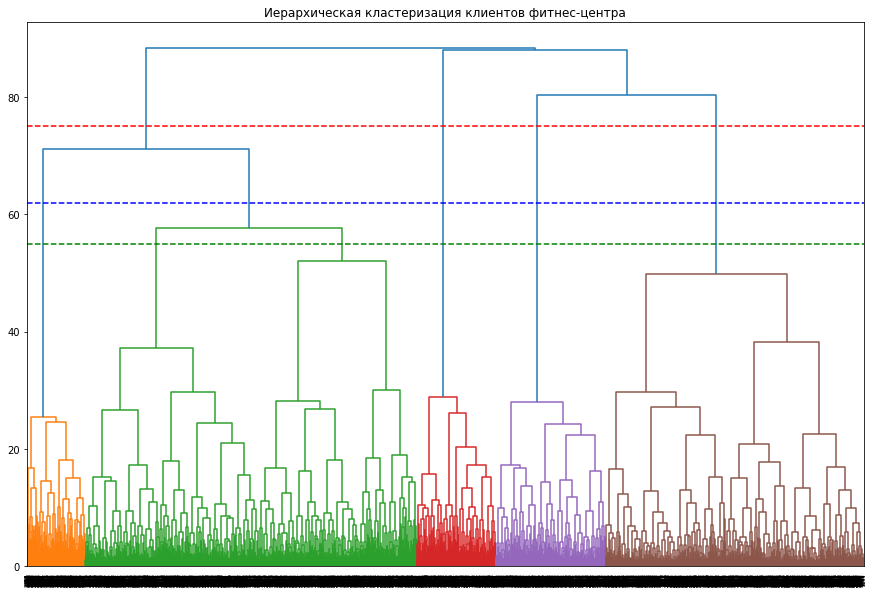

In [33]:
# Пострстроим дендрограмму:
plt.figure(figsize=(15, 10))  
dendrogram(linked, orientation='top')
plt.axhline(y=75, color='red', linestyle='--')
plt.axhline(y=62, color='blue', linestyle='--')
plt.axhline(y=55, color='green', linestyle='--')
plt.title('Иерархическая кластеризация клиентов фитнес-центра')
plt.show()

Исходя из дендрограммы, можно выделить пять кластеров. Обучим модель кластеризации на основании алгоритма `K-Means` и спрогнозируем кластеры клиентов. Разделим данные на **пять** кластеров методом `KMeans`.

In [34]:
# задаём модель k_means с числом кластеров 5 и фиксируем значение random_state
km = KMeans(n_clusters = 5, random_state = 0)
# прогнозируем кластеры для наблюдений 
labels = km.fit_predict(x_sc)

# сохраняем метки кластера в поле таблицы
gym['cluster_km'] = labels

Построим таблицу средних значений и посмотрим на средние значения признаков для кластеров.

In [35]:
gym_cluster = gym.groupby('cluster_km').mean().T
gym_cluster


cluster_km,0,1,2,3,4
gender,0.514894,0.502712,0.502053,0.513455,0.523684
near_location,0.948936,0.000000,0.998973,1.000000,0.860526
partner,0.697872,0.484629,0.820329,0.289559,0.468421
promo_friends,0.417021,0.084991,1.000000,0.000000,0.302632
phone,0.974468,1.000000,1.000000,1.000000,0.000000
group_visits,0.544681,0.235081,0.498973,0.401507,0.418421
age,29.893617,28.741410,29.334702,29.124865,29.294737
avg_additional_charges_total,165.080774,137.303883,149.758033,146.547445,144.480013
lifetime,5.021277,3.041591,4.032854,3.554898,3.957895
churn,0.055319,0.403255,0.170431,0.299247,0.271053


In [36]:
gym_cluster.T.style.background_gradient(cmap='coolwarm', axis=1).set_precision(2)

,gender,near_location,partner,promo_friends,phone,group_visits,age,avg_additional_charges_total,lifetime,churn,part_abonem,avg_frequency_mean
cluster_km,,,,,,,,,,,,
0,0.51,0.95,0.70,0.42,0.97,0.54,29.89,165.08,5.02,0.06,0.61,2.11
1,0.50,0.00,0.48,0.08,1.00,0.24,28.74,137.30,3.04,0.40,0.99,1.70
2,0.50,1.00,0.82,1.00,1.00,0.50,29.33,149.76,4.03,0.17,0.98,1.87
3,0.51,1.00,0.29,0.00,1.00,0.40,29.12,146.55,3.55,0.30,0.99,1.81
4,0.52,0.86,0.47,0.30,0.00,0.42,29.29,144.48,3.96,0.27,0.97,1.79


Средние значения признаков `phone`,`age`,  `gender` похожи по значениям.
Самая низкая доля оттока у клиентов нулевого кластера 5.5%, самая высокая доля оттока у клиентов первого кластера.
У клиентов первого кластера самый маленький лайфтайм в среднем 3 месяца и среденее значение посещений, также клиенты указанного кластера наименее охотно посещают групповые занятия, и проживают или работают вдали от фитнес-центра, и наименее платежеспособны.

Для клиентов нулевого кластера характерна самая низкая доля оттока, самый высокий средний лайфтайм равный пяти месяцам, и самая большая платежеспособность. 

Построим графики распределения признаков для кластеров.

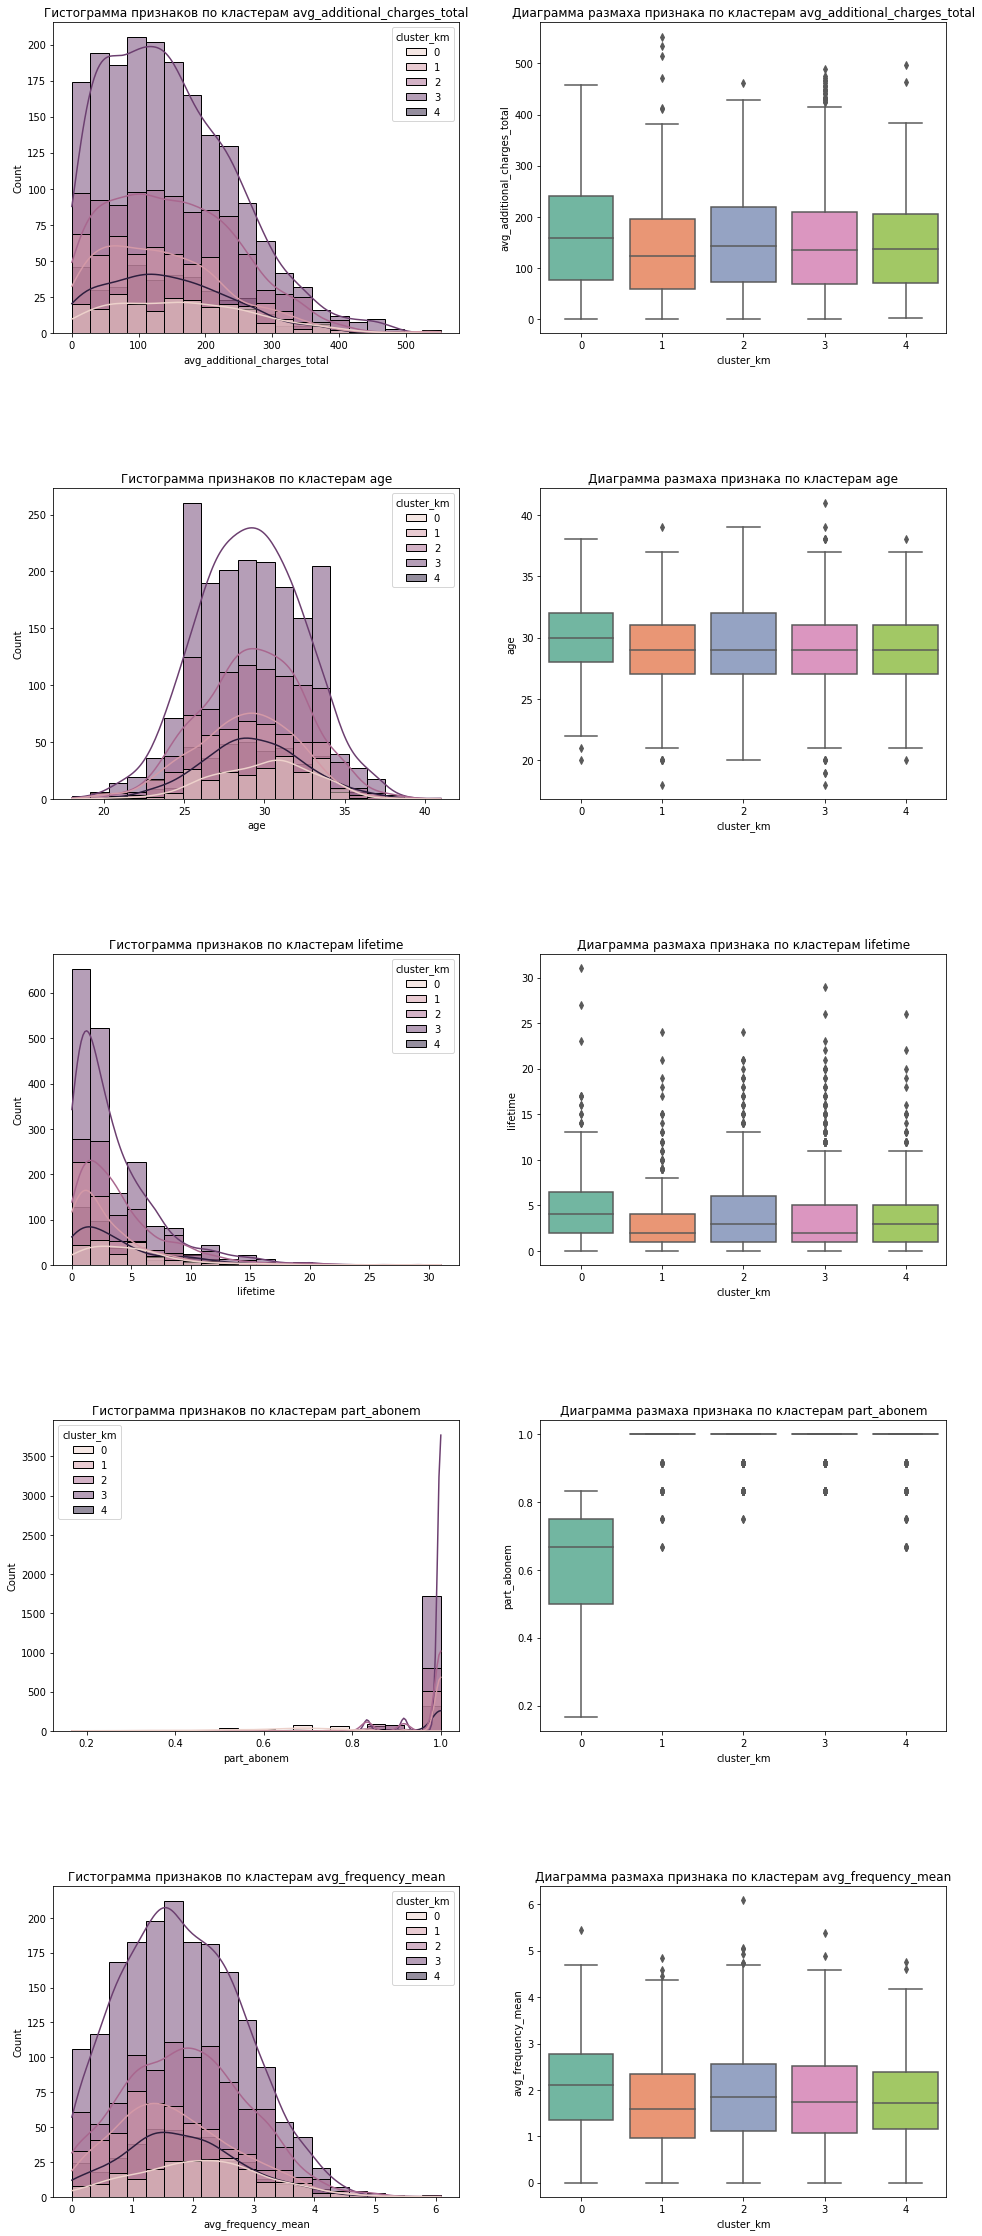

In [37]:

def plot_histogram_boxplot(dataset, numerical_columns):
    # Вычисляем количество количественных признаков
    num_numerical_columns = len(numerical_columns)

    # Рассчитываем количество строк и столбцов для subplot
    num_rows = num_numerical_columns
    num_cols = 2

    # Создаем subplot с учетом отступов
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(16, 8 * num_rows), gridspec_kw={'hspace': 0.5, 'wspace': 0.2})

    # Разделяем сабплоты на два списка
    histogram_axes = axes[:, 0]
    boxplot_axes = axes[:, 1]

    # Строим гистограммы
    for i in range(num_numerical_columns):
        col = numerical_columns[i]

        if col in dataset.columns:
            # Гистограмма
            sns.histplot(
                data=dataset,
                x=col, hue='cluster_km', 
                bins=20, ax=histogram_axes[i], 
                color="skyblue", 
                edgecolor='black', 
                kde=True,
                
                alpha=0.5
            )
            histogram_axes[i].set_title(f'Гистограмма признаков по кластерам {col}')
        else:
            print(f"Column {col} not found in the dataset.")

    # Строим диаграммы размаха
    for i in range(num_numerical_columns):
        col = numerical_columns[i]

        if col in dataset.columns:
            # Boxplot
            sns.boxplot(x='cluster_km', y=col, data=dataset, ax=boxplot_axes[i], palette='Set2')
            boxplot_axes[i].set_title(f'Диаграмма размаха признака по кластерам {col}')
        else:
            print(f"Column {col} not found in the dataset.")

    # Размещаем subplot
    plt.tight_layout()
    plt.show()



numerical_columns_list_2 = [
    'avg_additional_charges_total',
    'age', 'lifetime', 'part_abonem', 'avg_frequency_mean'
]
plot_histogram_boxplot(gym, numerical_columns_list_2 )

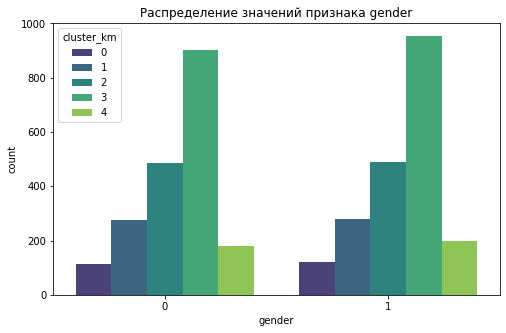

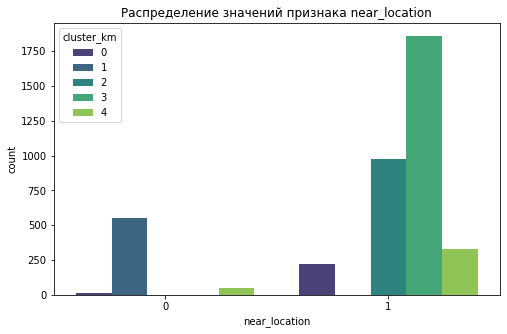

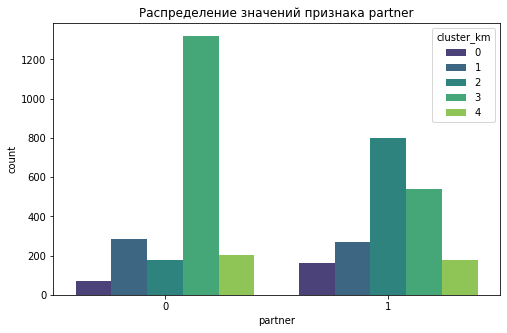

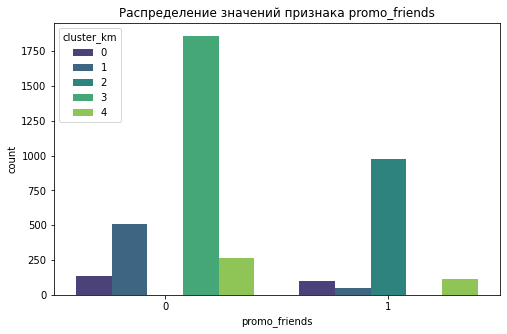

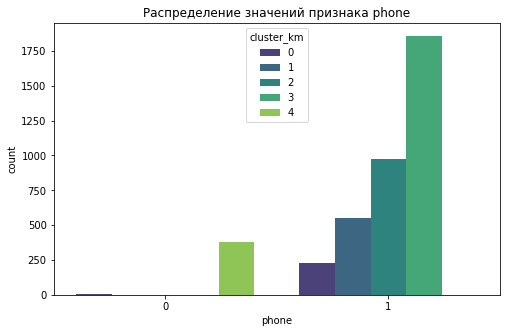

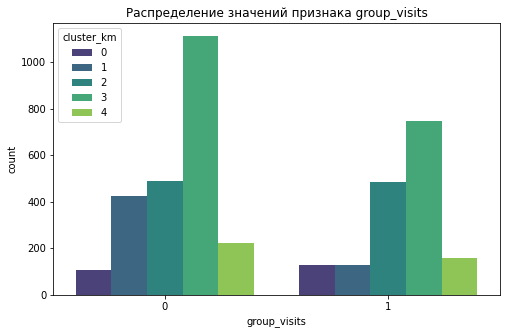

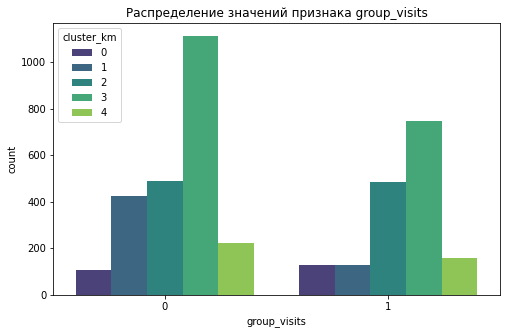

In [38]:
categorical_features_list_2 = [
    'gender', 'near_location', 'partner', 'promo_friends', 'phone', \
    'group_visits', 'group_visits'
]

for feature in categorical_features_list_2:
    plt.figure(figsize=(8, 5))
    sns.countplot(x=feature, hue='cluster_km', data=gym, palette="viridis")
    plt.title(f'Распределение значений признака {feature}')
    plt.show()

In [39]:
#for i in gym.drop(['cluster_km'], axis=1).columns:
    #fig, ax = plt.subplots(figsize = (10, 5))
   # sns.kdeplot(data=gym, x=i, hue='cluster_km', fill=True, alpha=0.4, ax = plt.subplot(1,2,1))
    #sns.histplot(data=gym, x=i, hue= 'cluster_km', ax = plt.subplot(1,2,2))
    #plt.show()

Графики распределения признаков подтверждают выводы, которые были сделаны ранее по таблице средних значений.

По графику можно добавить, что:


 - второй и третий кластер самые многочисленные;

 - клиенты из четвертого кластера не оставляют номера телефонов:
 
 - 60% клиентов первого кластера использовали промокод в рамках акции "приведи друга";
 
 - клиенты второго кластера далеко живут или работают;

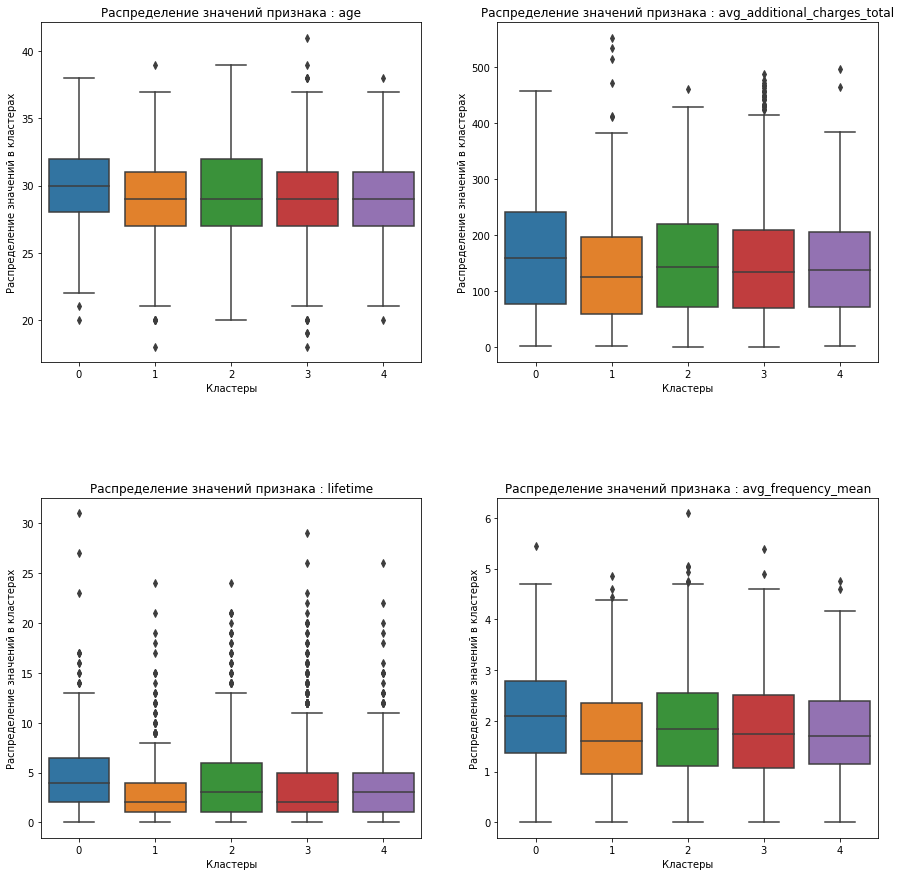

In [40]:
# построим список для столбцов с числовым распределением
list =  ['age','avg_additional_charges_total','lifetime','avg_frequency_mean', 'part_contract']
#задаем размер, обьявляем фигуру и оси
fig,axs = plt.subplots(2, 2)
fig.set_figheight(15)
fig.set_figwidth(15)
# задаем старт счетчика для индекса списка
count = 0
#задаем индекс строки
for i in range(len(axs)):
    # задаем индекс столбца
    for j in range(len(axs[0])):
        # строим боксплот, где по оси х будут кластеры, в разрезе количества уникальных значений
        sns.boxplot(data = gym, y =list[count], x ='cluster_km' ,ax =axs[i][j] )
        # оформляем график
        axs[i][j].set_title('Распределение значений признака : {}'.format(list[count]))
        axs[i][j].set_xlabel('Кластеры')
        axs[i][j].set_ylabel('Распределение значений в кластерах')
        count+=1       
# оформление графиков
plt.subplots_adjust(hspace = 0.4)
plt.show() 

Распределение числовых признаков для кластеров почти одинаковые с небольшим различием. Выбросов немного. 

Объединим изначальную таблицу `gym `с данными кластеризации. Затем сгруппируем данные, и посчитаем долю оттока.

In [41]:
churn_table = pd.concat([X, gym], axis=1, join='inner')
churn_table = churn_table.reset_index()
churn_table.head(3)

,index,gender,near_location,partner,promo_friends,phone,group_visits,age,avg_additional_charges_total,lifetime,...,promo_friends,phone,group_visits,age,avg_additional_charges_total,lifetime,churn,part_abonem,avg_frequency_mean,cluster_km
0,0,1,1,1,1,0,1,29,14.227470,3,...,1,0,1,29,14.227470,3,0,0.833333,0.010199,4
1,1,0,1,0,0,1,1,31,113.202938,7,...,0,1,1,31,113.202938,7,0,1.000000,1.916590,3
2,2,0,1,1,0,1,0,28,129.448479,2,...,0,1,0,28,129.448479,2,0,1.000000,1.797800,3


In [42]:
churn_table = churn_table.query('churn == 1').groupby(['cluster_km']).agg({'churn': 'count'}).reset_index()
churn_table

,cluster_km,churn
0,0,13
1,1,223
2,2,166
3,3,556
4,4,103


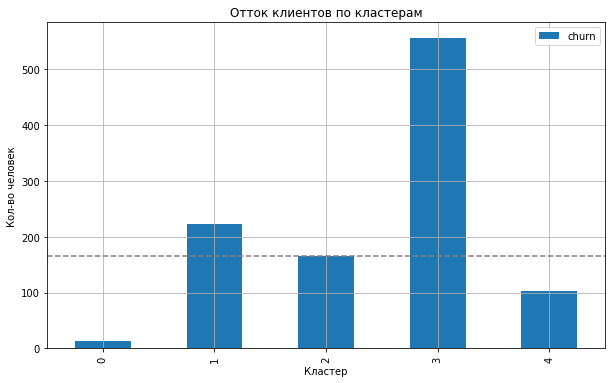

In [43]:
#Строим график отттока
churn_table.plot(x='cluster_km', y='churn', kind='bar', grid=True, figsize=(10,6))
plt.axhline(y=churn_table['churn'].median(), color='gray', linestyle='--')
plt.title('Отток клиентов по кластерам')
plt.xlabel('Кластер')
plt.ylabel('Кол-во человек')
plt.show()

Самые благонадежные клиенты в нулевом и четвертом кластерах, клиенты первого и третьего кластера склонные к оттоку. Отток клиентов второго кластера на медианном значении.

**Вывод**:

Сформированы пять кластеров клиентов фитнесс-центра.

Средние значения признаков `phone`,`age`,  `gender` похожи по значениям для всех кластеров.
Самая низкая доля оттока у клиентов нулевого кластера 5.5%, самая высокая доля оттока у клиентов первого кластера.
У клиентов первого кластера самый маленький лайфтайм в среднем 3 месяца и среденее значение посещений, также клиенты указанного кластера наименее охотно посещают групповые занятия, и проживают или работают вдали от фитнес-центра, и наименее платежеспособны.

Для клиентов нулевого кластера характерна самая низкая доля оттока, самый высокий средний лайфтайм равный пяти месяцам, и самая большая платежеспособность. 

второй и третий кластер самые многочисленные;

клиенты из четвертого кластера не оставляют номера телефонов:

60% клиентов первого кластера использовали промокод в рамках акции "приведи друга";

клиенты второго кластера далеко живут или работают;

Распределение числовых признаков для кластеров почти одинаковые с небольшим различием. Выбросы единичные.

Самые благонадежные клиенты в нулевом и четвертом кластерах, клиенты первого и третьего кластера склонные к оттоку. Отток клиентов второго кластера на медианном значении.

## Общий вывод:


<p></p>

<div style="border:solid green 2px; padding: 20px">
    
**1. Обзор данных.**

Произведен первичный обзор данных. Доступны сведения о 4000 клиентах фитнес-центра, и по каждому клиенту 14 колонок-атрибутов, включая целевую переменную `churn`. Пропуски отсутствуют.

Большинство признаков являются категориальными. К числовым признакам относятся столбцы: 
 - `Avg_class_frequency_total`: средняя частота посещений в неделю за все время;
 - `Avg_class_frequency_current_month`: средняя частота посещений в неделю за предыдущий месяц;
 - `Avg_additional_charges_total`: суммарная выручка от других услуг фитнес-центра.    
    
**2. Исследовательский анализ данных**  
    
 В данных отсутствуют дубликаты.

 - по признаку `gender` распределение между мужчинами и женщинами одинаковое;
 - 84% пользователей проживают или работают рядом с фитнес-центром;
 - почти половина клиентов являются сотрудниками компаний-партнеров клуба и получают скидку на абонемент;
 - 30% клиентов привлечены в рамках акции "приведи друга";
 - фитнес-центр обладает телефонами 90% своих пользователей; соответственно 10% клиентов отказались указать свои номера телефонов;
 - почти половина пользователей: 41% посещают групповые занятия;
 - 26% клиентов попадут в отток в следующем месяце (перестанут посещать занятия)
 
 - в столбце `avg_additional_charges_total` наблюдаются небольшие выбросы, медианная выручка от других услуг 146 у.е.
 
 - средний возраст посетителя фитнес-центра составляет 29 лет.
 
 - средняя частота посещений фитнес-центра за предыдущий месяц составляет 1.71 раз в неделю.
 
 - средняя частота посещений фитнес-центра за все время составляет 1.83 раз в неделю.
 
 
 - на гистограмме наблюдается большое количество людей, которые за предыдущий месяц не посещали фитнес-центр: в большинстве случаев такие пользователи являются новыми клиентами или клиентами, которые прекратили посещать занятия через месяц, после первого обращения.
 
Изучены средние значения признаков, по которым сформированы выводы: 

 - такие признаки, как пол, близость проживания или работа возле фитнесс-центра, наличие телефона в базе фитнес-центра не влияют на значения целевой переменной.

- среди оставшихся более половины клиентов являются сотрудниками компании-партнера клуба и пользуются скидками, а среди ушедших в отток всего лишь треть таких клиентов. Можно сделать вывод, что признак принадлежности клиента к сотрудникам компании партнера-клуба оказывает положительное влияние на удержание пользователя, в то время, как среди ушедших в отток клиентов больше тех, кто не является сотрудником партнера.

- среди оставшихся пользователей 35% использовали промокод в рамках акции "приведи друга", в то время, как среди ушедших в отток таких пользователей всего лишь 18%.
 
- среди оставшихся пользователей средняя длительность действующего абонемента намного больше, чем среди ушедших в отток: почти полгода против 1.72 месяца, показатели почти совпадают и со средним сроком до окончания текущего действующего абонемента.

- почти половина среди оставшихся клиентов посещают групповые занятия, среди ушедших в отток таких клиентов всего четверть.

- средний возраст оставшихся клиентов на три года старше среднего возраста клиентов, ушедших в отток: 30 лет и 27 лет.

- оставшиеся пользователи охотнее пользуются дополнительными услугами фитнес-центра: средняя суммарная выручка составляет 158 тыс. у.е, среди ушедших в отток средняя суммарная выручка 115 тыс. у.е. 

- среди оставшихся пользователей гораздо больше "долгожителей": время с момента первого обращения в фитнес-центр составляет 4.7 месяцев, среди ушедших в отток лайфтайм составляет около одного месяца.

- оставшиеся пользователи в среднем в текущем месяце посещают тренировки 2 раза в неделю, пользователи, ушедшие в отток посещали в среднем полтора раза в неделю, а за предыдущий месяц ушедшие в отток посещали занятия всего лишь один раз в неделю.

- Признаки `month_to_end_contract`, `contract_period` и `avg_class_frequency_current_month`, `avg_class_frequency_total` мультиколлинеарны, поэтому принято решение для уменьшения вероятности переобучения модели, на основании мультиколлинеарных признаков, ввести новые признаки: остаток абонемента и среднее значение посещений с поправкой на количество посещений предыдущей недели. 
- Наибольшая заметная корреляция с целевой переменной наблюдается у признаков возраст пользователя и лайфтайм, умеренная корреляция со среденим значением посещений с поправкой на количество посещений предыдущей недели.
    
- Наблюдается слабая линейная связь практически между всеми признаками, однако такие признаки, как пол и наличие телефона не отражают никаких связей с другими признаками.

- Видна средняя заметная связь между категориальными признаками `promo_friends` и `partner`, можно предположить, что участники акции "приведи друга" являются в небольшой доле сотрудниками компании-партнера, и привлекают новых клиентов среди своих коллег, однако такая гипотеза требует отдельного исследования. 

- Наблюдается средняя умеренная корреляция между категориальными признаками `partner` и `month_to_end_contract`: скорее всего сотрудники компании-партнера охотнее приобретают абонементы.

- С категориальной целевой переменной `churn` сильнее всего коррелирует признак `lifetime` - корреляция заметная, а также такие признаки, как `age`, `month_to_end_contract`, `avg_class_frequency_current_month`.
    
    
**3. Прогнозирование оттока клиентов**    

Построена модель бинарной классификации. Модель обучена способом логической регрессии и случайным лесом.
    
Результаты проверки модели на валидационной выборке на основании метрик показали, что немного лучший прогноз даёт модель логистической регрессии.

Доля правильных ответов `accuracy` 88%. 

Доля правильных ответов `precision` имеет важное значение и составляет 76% только среди целевого класса `1`.  
`recall` на уровне 77%, тоже на высоком уровне. 
Баланс `F1`, показывает хороший результат на уровне 76%.
Метрика оценки качества классификатора `ROC_AUC` показывает значение в 94% и стремится к 100%.    
    
    
**4. Кластеризация. **   
    
Сформированы пять кластеров клиентов фитнесс-центра.

Средние значения признаков `phone`,`age`,  `gender` похожи по значениям для всех кластеров.
Самая низкая доля оттока у клиентов нулевого кластера 5.5%, самая высокая доля оттока у клиентов первого кластера.
У клиентов первого кластера самый маленький лайфтайм в среднем 3 месяца и среденее значение посещений, также клиенты указанного кластера наименее охотно посещают групповые занятия, и проживают или работают вдали от фитнес-центра, и наименее платежеспособны.

Для клиентов нулевого кластера характерна самая низкая доля оттока, самый высокий средний лайфтайм равный пяти месяцам, и самая большая платежеспособность. 

второй и третий кластер самые многочисленные;

клиенты из четвертого кластера не оставляют номера телефонов:

60% клиентов первого кластера использовали промокод в рамках акции "приведи друга";

клиенты второго кластера далеко живут или работают;

Распределение числовых признаков для кластеров почти одинаковые с небольшим различием. Выбросы единичные.

Самые благонадежные клиенты в нулевом и четвертом кластерах, клиенты первого и третьего кластера склонные к оттоку. Отток клиентов второго кластера на медианном значении.    
</div>